In [2]:
# read in the data from the csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in the data from the csv file
data=pd.read_csv("/Users/liufanling/Library/CloudStorage/OneDrive-个人/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_T1/Activity/Compiled_ActivityScan.csv")

In [3]:
# check unique chip IDs
chip_ids = data['Chip_ID'].unique()
chip_ids

array(['M06691', 'M07036', 'M07301', 'M07309'], dtype=object)

In [4]:
# Screening criteria
# Criteria 1: screen CHIP_ID with Active_area consistently smaller than 35 across all 'DIV'
grouped_data = data.groupby(['Chip_ID', 'Well'])

# Filter out groups where all Active_area values are less than 35
data_screen = grouped_data.filter(lambda x: all(x['Active_area'] < 35))

# Display the filtered data
data_screen_unique_units = data_screen.drop_duplicates(subset=['Chip_ID', 'Well'])
data_screen_unique_units

,Run_ID,DIV,Well,NeuronType,Time,Chip_ID,Mean_FiringRate,Mean_SpikeAmplitude,Active_area
11,7,4,6,HET,25-Mar-2024 13:49:55,M07036,1.67575,41.449051,7.909091


In [5]:
# Criteria 2: Filter out groups where any Active_area values are less than 35 after DIV 4 and DIV 7

# subset drop div 4 and div 7
data_subset = data[data['DIV'] > 7]

data_outliers = data_subset[data_subset['Active_area']<=35]

data_outliers_unique = data_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations
print(data_outliers_unique)

    Chip_ID  Well
59   M07036     6
66   M07309     1
68   M07309     3
152  M07036     3
156  M07301     1
163  M07309     2


In [6]:
# Criteria 3: Filter out groups where any Active_area values based on IQR
data_subset = data[data['DIV'] > 7]
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_subset['Active_area'].quantile(0.25)
Q3 = data_subset['Active_area'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'Active_area' is an outlier
data_iqr_outliers = data_subset[(data_subset['Active_area'] < lower_bound) | (data_subset['Active_area'] > upper_bound)]

# Identify the unique combinations of Chip_ID and Well after filtering
data_iqr_outliers_unique = data_iqr_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations
print(data_iqr_outliers_unique)

    Chip_ID  Well
131  M07036     6
164  M07309     3


In [12]:
# Criteria 4: Filter out groups where any Active_area values based on Z-score
from scipy import stats

# Calculate the Z-scores for the 'Active_area' column and assign using .loc to avoid the warning
data_subset.loc[:, 'Z_score'] = stats.zscore(data_subset['Active_area'])

# Define a threshold for identifying outliers (commonly Z > 3 or Z < -3)
z_threshold = 2

# Filter out rows where 'Active_area' is an outlier based on Z-score
data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]

# Identify the unique combinations of Chip_ID and Well for the outliers
data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations of outliers
print(data_z_outliers_unique)

    Chip_ID  Well
59   M07036     6
164  M07309     3
176  M07036     3


In [8]:
# Compare results of all outlier detection methods
# Create dataframes for each criteria's results
criteria_1 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309', 'M07309', 'M07036', 'M07301', 'M07309'],
    'Well': [6, 1, 3, 3, 1, 2]
})

criteria_2 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309'],
    'Well': [6, 3]
})

criteria_3 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309', 'M07036'],
    'Well': [6, 3, 3]
})

# Merge the dataframes for comparison
comparison_table = criteria_1.merge(criteria_2, on=['Chip_ID', 'Well'], how='outer', indicator='Criteria_2').merge(
    criteria_3, on=['Chip_ID', 'Well'], how='outer', indicator='Criteria_3')

# Adjust indicators for readability
comparison_table['Criteria_2'] = comparison_table['Criteria_2'].apply(lambda x: 'Yes' if x == 'both' else 'No')
comparison_table['Criteria_3'] = comparison_table['Criteria_3'].apply(lambda x: 'Yes' if x == 'both' else 'No')

# Rename columns for clarity
comparison_table = comparison_table.rename(columns={'Criteria_2': 'In Criteria 2', 'Criteria_3': 'In Criteria 3'})

# Fill in for Criteria 1 (since it was the base)
comparison_table['In Criteria 1'] = 'Yes'

# Reorder columns
comparison_table = comparison_table[['Chip_ID', 'Well', 'In Criteria 1', 'In Criteria 2', 'In Criteria 3']]
comparison_table
# export the comparison table to a CSV file at certain path
# path = '/Users/liufanling/Library/CloudStorage/OneDrive-个人/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_T1/Outlier_detection'

# comparison_table.to_csv(path+'comparison_table.csv', index=False)


,Chip_ID,Well,In Criteria 1,In Criteria 2,In Criteria 3
0,M07036,3,Yes,No,Yes
1,M07036,6,Yes,Yes,Yes
2,M07301,1,Yes,No,No
3,M07309,1,Yes,No,No
4,M07309,2,Yes,No,No
5,M07309,3,Yes,Yes,Yes


<Figure size 1400x1000 with 0 Axes>

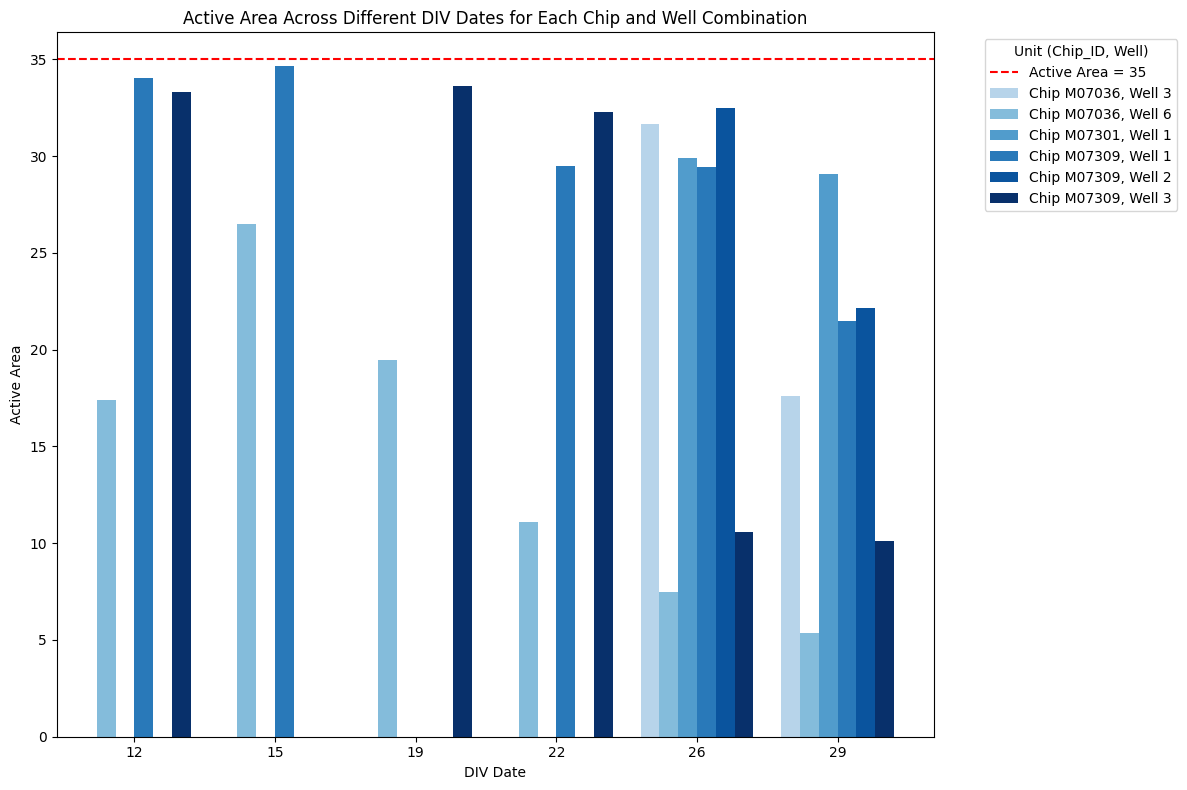

In [9]:
# Plotting the active area across different DIV dates for each Chip and Well combination
pivot_data = data_outliers.pivot_table(index=['DIV'], columns=['Chip_ID', 'Well'], values='Active_area')
num_units = len(pivot_data.columns)
# Generating different shades of blue for each unit
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))

# Adjusting the plot to make the bars from different units at the same DIV distribute side by side in a vertical orientation
plt.figure(figsize=(14, 10))

# Re-calculating the pivot data since it seems not in scope here


# Define the number of units and calculate the width of each bar based on the number of units
num_units = len(pivot_data.columns)
total_width = 0.8  # Total space allocated for all bars at each DIV date
bar_width = total_width / num_units  # Width of each individual bar

# Plot setup
plt.figure(figsize=(12, 8))

# Plotting
for index, (column, series) in enumerate(pivot_data.items()):
    # Position each bar based on its order in the dataframe
    positions = [x - (total_width - bar_width) / 2 + index * bar_width for x in range(len(pivot_data))]
    plt.bar(positions, series.values, width=bar_width, color=colors[index], label=f'Chip {column[0]}, Well {column[1]}')

# Adding a horizontal dashed line at Active Area = 35 for reference
plt.axhline(y=35, color='r', linestyle='--', linewidth=1.5, label='Active Area = 35')

# Labeling and aesthetics
plt.xlabel('DIV Date')
plt.ylabel('Active Area')
plt.title('Active Area Across Different DIV Dates for Each Chip and Well Combination')
plt.xticks(range(len(pivot_data)), pivot_data.index)  # Set x-ticks to be the DIV dates
plt.legend(title="Unit (Chip_ID, Well)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

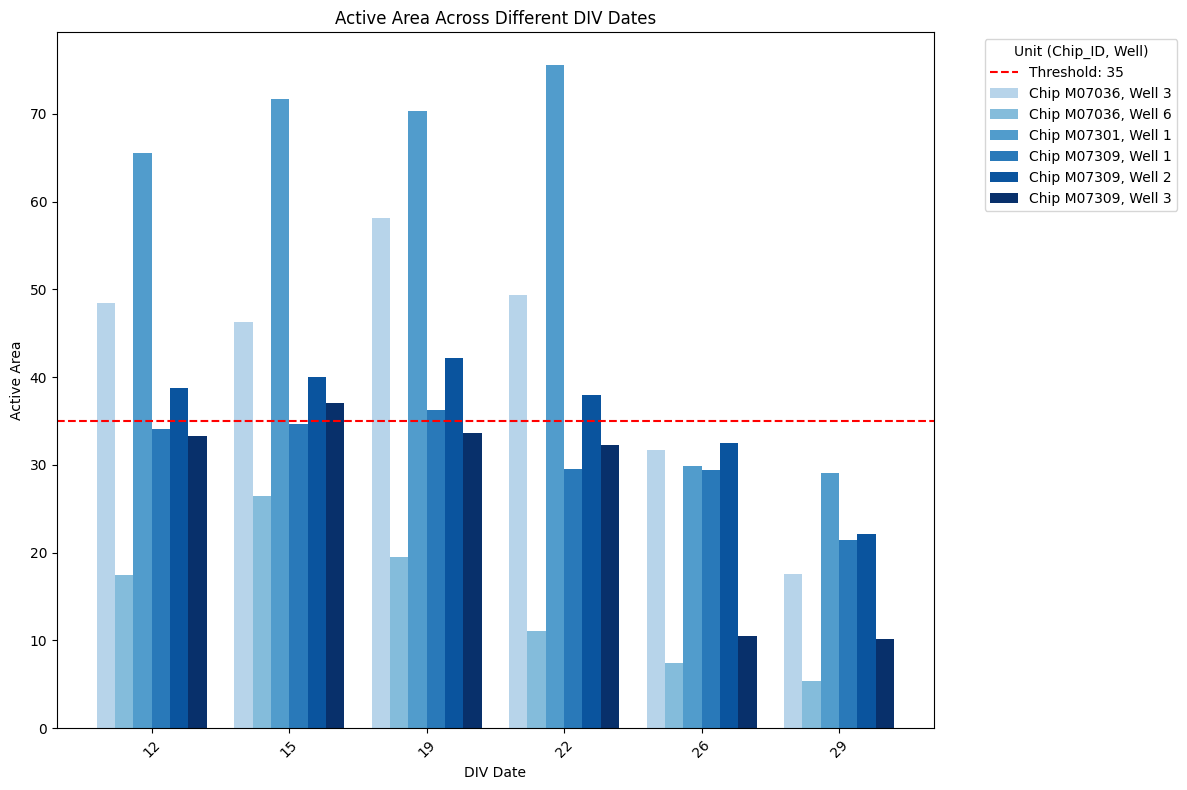

In [10]:
# Include all DIV data for units with Active_area <= 35

units_with_low_area = data_subset[data_subset['Active_area'] <= 35][['Chip_ID', 'Well']].drop_duplicates()

# Filter the original dataset to include all DIV data for these units
filtered_data = data_subset.merge(units_with_low_area, on=['Chip_ID', 'Well'])

# Create a pivot table
pivot_data = filtered_data.pivot_table(index='DIV', columns=['Chip_ID', 'Well'], values='Active_area', aggfunc='first')

# Plot setup
num_units = len(pivot_data.columns)
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))
total_width = 0.8  # Total width for bars at each DIV date
bar_width = total_width / num_units  # Width of each bar

# Plot setup
plt.figure(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))

total_width = 0.8
bar_width = total_width / len(pivot_data.columns)

# Plotting each set of bars
for i, ((chip_id, well), series) in enumerate(pivot_data.items()):
    # Offset positions for each bar group
    positions = np.arange(len(pivot_data)) - (total_width - bar_width) / 2 + i * bar_width
    plt.bar(positions, series, width=bar_width, color=colors[i], label=f'Chip {chip_id}, Well {well}')

# Adding the horizontal line and labels
plt.axhline(y=35, color='red', linestyle='--', label='Threshold: 35')
plt.xlabel('DIV Date')
plt.ylabel('Active Area')
plt.title('Active Area Across Different DIV Dates')
plt.xticks(np.arange(len(pivot_data)), pivot_data.index, rotation=45)
plt.legend(title="Unit (Chip_ID, Well)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

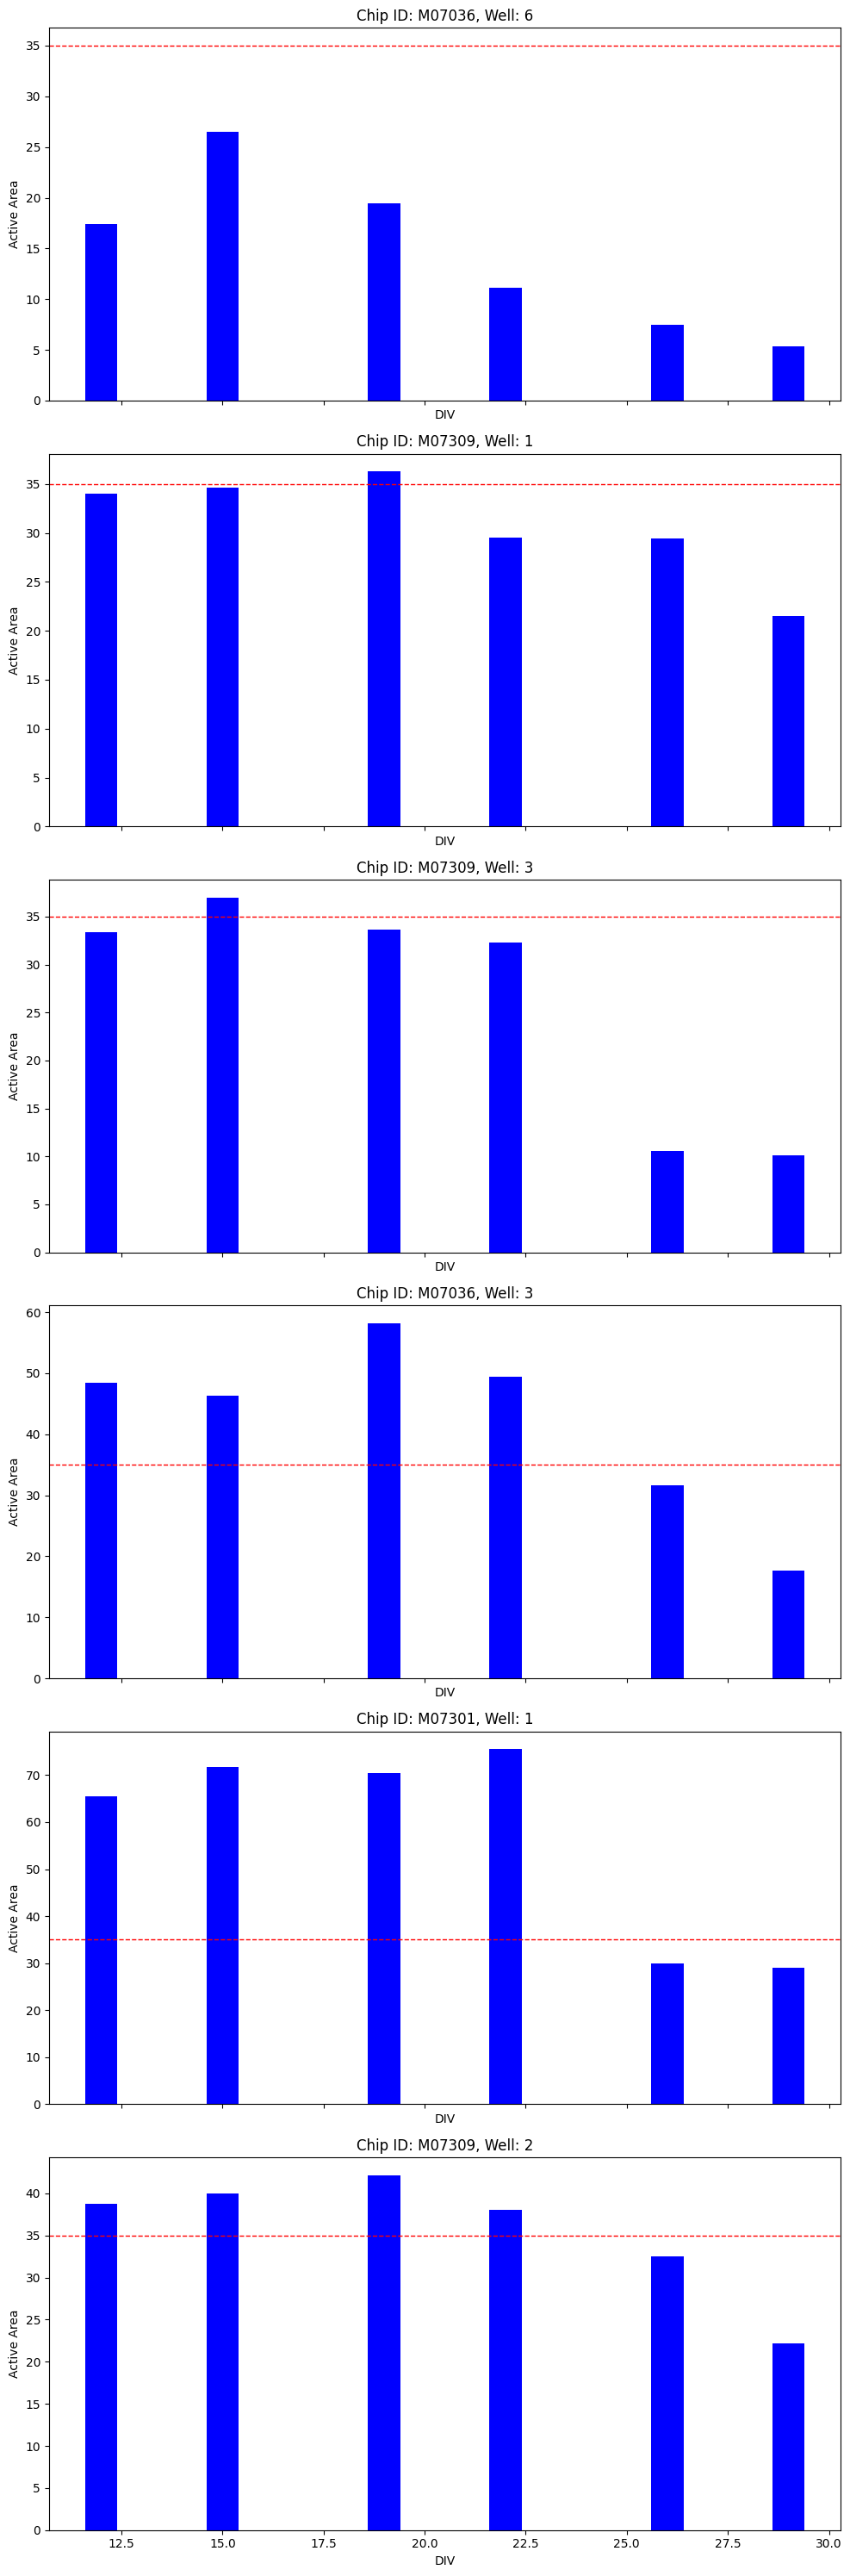

In [11]:
# Check single unit seperately

fig, axs = plt.subplots(nrows=len(data_outliers_unique), ncols=1, figsize=(10, 5 * len(data_outliers_unique)), sharex=True)

# Ensure axs is iterable if there's only one plot
if len(data_outliers_unique) == 1:
    axs = [axs]

for ax, (idx, row) in zip(axs, data_outliers_unique.iterrows()):
    # Extract the full data for this specific unit from the original dataset
    unit_data = data_subset[(data_subset['Chip_ID'] == row['Chip_ID']) & (data_subset['Well'] == row['Well'])]
    ax.bar(unit_data['DIV'], unit_data['Active_area'], color='b')
    ax.axhline(y=35, color='r', linestyle='--', linewidth=1)
    ax.set_title(f"Chip ID: {row['Chip_ID']}, Well: {row['Well']}")
    ax.set_xlabel('DIV')
    ax.set_ylabel('Active Area')

plt.tight_layout()
plt.show()